In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets
import os
import random

# Load the dataset
file_path = '/content/drive/Shareddrives/עיבוד שפה טבעית/Data/MELD.Raw/test_sent_emo.csv'
annotated_path = '/content/drive/Shareddrives/עיבוד שפה טבעית/Data/annotated_test_sent_emo_omer.csv'

if os.path.exists(annotated_path):
    data = pd.read_csv(annotated_path)
else:
    data = pd.read_csv(file_path)

# Create empty columns for annotators' roles if not present
annotators = ['Guy', 'Amit', 'Noa', 'Omer']
for annotator in annotators:
    column_name = f'{annotator} Role'
    if column_name not in data.columns:
        data[column_name] = None

# Define roles with descriptions
roles = {
    'Protagonist': 'Leads the discussion and asserts authority, actively driving the conversation forward.',
    'Supporter': 'Offers encouragement, help, or positive reinforcement to other speakers.',
    'Neutral': 'Participates passively, often giving straightforward responses or reacting without adding substantial direction or conflict.',
    'Gatekeeper': 'Facilitates smooth communication, guides turn-taking, or helps clarify misunderstandings, ensuring the conversation remains balanced and productive.',
    'Attacker': 'Challenges others, expresses skepticism, or undermines the ideas and confidence of other speakers, introducing tension or conflict into the interaction.'
}

# Define role translation mapping for display
role_translation_map = {
    'Protagonist': 'Protagonist (מוביל דיון)',
    'Supporter': 'Supporter (מצדד, מחזק)',
    'Neutral': 'Neutral (ניטרלי)',
    'Gatekeeper': 'Gatekeeper (מווסת תקשורת, מגשר)',
    'Attacker': 'Attacker (תקיף)'
}

# Reverse mapping for saving
reverse_translation_map = {v: k for k, v in role_translation_map.items()}

# Group data by Dialogue_ID
grouped_data = data.groupby('Dialogue_ID')

# Function to annotate dialogues
def annotate_dialogue(dialogue_id, annotator):
    clear_output()

    # Display annotator selection and role definitions
    print(f"Annotating for: {annotator}")
    print("Speaker Role Definitions:")
    for role, description in roles.items():
        print(f"- **{role}**: {description}")
    print("\n")

    # Display the context for the current dialogue
    group = grouped_data.get_group(dialogue_id)
    print(f"\nDialogue_ID: {dialogue_id}")
    print("Context:")
    for _, row in group.iterrows():
        print(f"{row['Speaker']}: {row['Utterance']}")
    print("\n\n\n")

    # Generate a list of distinct colors
    def generate_colors(n):
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'teal', 'darkgoldenrod', 'magenta', 'darkcyan']
        random.shuffle(colors)
        return colors[:n]

    # Identify unique speakers and assign them colors
    unique_speakers = data['Speaker'].unique()
    speaker_colors = {speaker: color for speaker, color in zip(unique_speakers, generate_colors(len(unique_speakers)))}

    # Find the longest utterance length for dynamic width
    max_text_length = max(len(f"{row['Speaker']}: {row['Utterance']}") for _, row in group.iterrows())
    estimated_width = f"{max_text_length * 7}px"  # Adjust scaling factor as needed

    widgets_list = []
    row_indices = []

    for index, row in group.iterrows():
        speaker_color = speaker_colors.get(row['Speaker'], 'black')  # Default to black if not found

        # Format speaker name in bold with dynamic color
        formatted_text = f"<b style='color: {speaker_color};'>{row['Speaker']}:</b> {row['Utterance']}"

        # Create an HTML widget for styled text
        utterance_label = widgets.HTML(
            value=formatted_text,
            layout=widgets.Layout(width=estimated_width)
        )

        # Retrieve stored role, translating for display
        saved_role = row[f'{annotator} Role']
        displayed_value = role_translation_map.get(saved_role, None) if pd.notnull(saved_role) else None

        # Create a dropdown for role selection
        role_dropdown = widgets.Dropdown(
            options=[(role_translation_map[key], key) for key in roles.keys()],  # Display translated text, store original
            value=saved_role if pd.notnull(saved_role) else None,
            layout=widgets.Layout(width='auto')
        )

        widgets_list.append(widgets.HBox([utterance_label, role_dropdown], layout=widgets.Layout(width='100%')))
        row_indices.append(index)

    # Save button
    save_button = widgets.Button(
        description="Save",
        button_style='success',
        tooltip="Click to save the annotations"
    )

    def save_annotations(_):
        for dropdown, idx in zip(widgets_list, row_indices):
            selected_value = dropdown.children[1].value  # Retrieve original English value
            data.loc[idx, f'{annotator} Role'] = selected_value

        data.to_csv(annotated_path, index=False)
        print(f"Annotations saved for Dialogue_ID {dialogue_id} by {annotator}.")

        next_id = find_incomplete_dialogue(annotator)
        if next_id is not None:
            annotate_dialogue(next_id, annotator)
        else:
            clear_output()
            print(f"Annotation Complete for {annotator}!")
            print(f"All annotations have been saved to {annotated_path}.")

    save_button.on_click(save_annotations)
    display(*widgets_list, save_button)

# Helper function to get the next incomplete Dialogue_ID
def get_next_incomplete_dialogue(current_id, annotator):
    dialogue_ids = list(grouped_data.groups.keys())
    for dialogue_id in dialogue_ids[dialogue_ids.index(current_id):]:
        group = grouped_data.get_group(dialogue_id)
        if group[f'{annotator} Role'].isnull().any():
            return dialogue_id
    return None

# Function to find the first incomplete Dialogue_ID for an annotator
def find_incomplete_dialogue(annotator):
    dialogue_ids = sorted([dialogue_id for dialogue_id in grouped_data.groups.keys() if dialogue_id >= 135], reverse=True)
    for dialogue_id in dialogue_ids:
        group = grouped_data.get_group(dialogue_id)
        if group[f'{annotator} Role'].isnull().any():
            return dialogue_id
    return None

# Annotator selection dropdown
annotator_dropdown = widgets.Dropdown(
    options=annotators,
    description="Annotator:",
    value=annotators[0]
)

# Start button
start_button = widgets.Button(
    description="Start Annotation",
    button_style='primary',
    tooltip="Click to start the annotation process"
)

def start_annotation(_):
    selected_annotator = annotator_dropdown.value
    first_incomplete_id = find_incomplete_dialogue(selected_annotator)
    if first_incomplete_id is not None:
        annotate_dialogue(first_incomplete_id, selected_annotator)
    else:
        clear_output()
        print(f"All annotations are complete for {selected_annotator}.")

start_button.on_click(start_annotation)
display(annotator_dropdown, start_button)


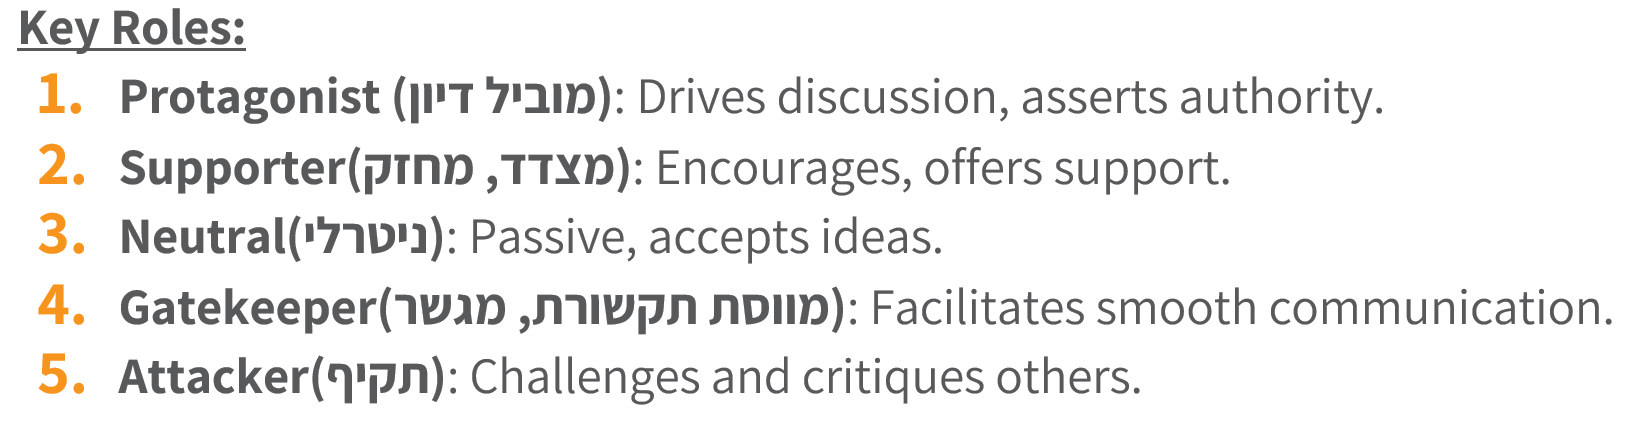